# Classification using a Neural Network - Handle Class Imbalance (Pytorch)
The dataset is from https://www.kaggle.com/c/GiveMeSomeCredit <br>
"Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted."  <br>
We will build an MLP classifier to predict if someone will experience financial distress and therefore cannot pay off credit card (i.e. default). It is a binary classificaiton problem: default (class-1) or not default  (class-0) <br>
Real dataset is often imbalanced: class-i may have much more data samples than class-j.

In [1]:
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import pandas as pd
import torch

### Load the data

In [2]:
#every row of the table is a data sample (feature vector) from a person
df = pd.read_csv('cs_data.csv')
df.head()

,id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


#### handle nan (null) in data (i.e. missing values)
Some fields in the table are nan, which are missing values. <br>
For example, someone may not want to reveal monthly income to whoever made the table/survey, then the table got nan.

In [3]:
df.isnull().sum()

id                                          0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [4]:
#here, we use a simple method:
#replace nan in each column with median value of that column
#there are other methods in pandas and sklearn: interpolation in pandas and KNNImputer in sklearn
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
dfv=imputer.fit_transform(df.values)
df=pd.DataFrame(data=dfv, columns=df.columns)
df.isnull().sum()

id                                      0
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

### We have a highly imbalanced dataset
139974 data samples in class-0 (normal) <br>
10026 data samples in class-1 (financial distress)

<AxesSubplot:>

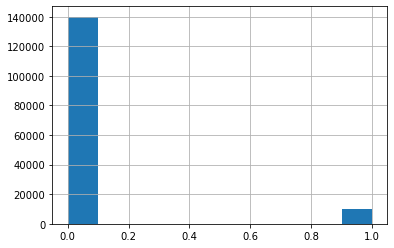

In [5]:
df['SeriousDlqin2yrs'].hist()

#### Classification Goal: predict 'SeriousDlqin2yrs' (Y) using the other features (X)

In [6]:
#'SeriousDlqin2yrs' is the target/class label, so it should not be in the input feature vector X
#'id' of a person is useless for the classification task
#so, we remove them from the table and get the input X
X=df.drop(['SeriousDlqin2yrs', 'id'], axis=1)
X.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.766127,45.0,2.0,0.802982,9120.0,13.0,0.0,6.0,0.0,2.0
1,0.957151,40.0,0.0,0.121876,2600.0,4.0,0.0,0.0,0.0,1.0
2,0.658180,38.0,1.0,0.085113,3042.0,2.0,1.0,0.0,0.0,0.0
3,0.233810,30.0,0.0,0.036050,3300.0,5.0,0.0,0.0,0.0,0.0
4,0.907239,49.0,1.0,0.024926,63588.0,7.0,0.0,1.0,0.0,0.0


In [7]:
#Y is the target/class label
Y=df['SeriousDlqin2yrs']
Y.head()

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: SeriousDlqin2yrs, dtype: float64

In [8]:
# convert pandas dataframe/series to numpy array
# sklearn functions may not work well with pandas data types
X=X.values
Y=Y.values

### create training, validation and test sets

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
#split X_train and Y_train into a 'pure' training set and a validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)
print('train:', X_train.shape, Y_train.shape)
print('validation:', X_val.shape, Y_val.shape)
print('test:', X_test.shape, Y_test.shape)

train: (108000, 10) (108000,)
validation: (12000, 10) (12000,)
test: (30000, 10) (30000,)


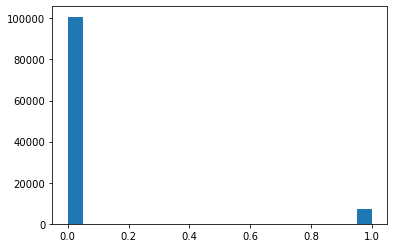

In [10]:
plt.hist(Y_train, bins=20);

Let's do upsampling for class-1

In [11]:
from sklearn.utils import resample
X_train_c1  = resample(X_train[Y_train==1], n_samples=100824)
Y_train_c1 = np.ones(X_train_c1.shape[0])
print('X_train_c1', X_train_c1.shape, Y_train_c1.shape)
X_train=np.concatenate([X_train[Y_train==0], X_train_c1], axis=0)
Y_train=np.concatenate([Y_train[Y_train==0], Y_train_c1], axis=0)
print('X_train.shape after upsampling', X_train.shape)
print('Y_train.shape after upsampling', Y_train.shape)

X_train_c1 (100824, 10) (100824,)
X_train.shape after upsampling (201648, 10)
Y_train.shape after upsampling (201648,)


In [12]:
#apply feature normalization to training, validation and test sets
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(X_train) # think about why fit to X_train, not X ?
X_train=scaler.transform(X_train)
X_val=scaler.transform(X_val)
X_test=scaler.transform(X_test)

### we need to use weighted classification accuracy

In [13]:
# we need to use weighted classification accuracy
# try to understand it
def weighted_accuracy(confusion):
    #input: confusion is the confusion matrix
    #output: acc is the weighted classification accuracy
    M=confusion.copy().astype('float32')
    for k in range(0, M.shape[0]):
        M[k]/=M[k].sum()+1e-8    
    acc = M.diagonal().sum()/M.sum()
    return acc

## Your task begins here <br>
see NN_binary_classification_Pytorch.ipynb in Lecture 16 <br>
try Adma with lr=0.001 <br>
Usually, we need to tune the hyperparameters of a neural network, <br>
such as the number of layers, the number of units in each layer <br>
If you have plenty of time and enough computing power, try to find better hyperparameters <br>
read papers about "Neural Architecture Search" https://arxiv.org/abs/1808.05377 <br>

You need to modify the function `test` in order to use weighted_accuracy, see `test_acc` in H3P2T1_Keras.ipynb

### define a dataset to hold/represent the data 

In [14]:
from torch.utils.data import Dataset as torch_dataset

class MyDataset(torch_dataset):
    def __init__(self, X, Y):
        self.X=X
        self.Y=Y
    def __len__(self):
        #return the number of data points
        return self.X.shape[0]
    def __getitem__(self, idx):
        # self.X[idx] is numpy array, we need to convert it to torch tensor
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.Y[idx], dtype=torch.float32) #it needs to be float, not int
        return x, y

Create instance objects of the `MyDataset` class <br>
a training dataset `dataset_train` <br>
a validation dataset `dataset_val` <br>
a testing dataset `dataset_test` <br>

In [15]:
dataset_train = MyDataset(X_train, Y_train)
dataset_val = MyDataset(X_val, Y_val)
dataset_test = MyDataset(X_test, Y_test)

In [16]:
# get the first data point in the training set
# dataset_train[0][0] is x0
# dataset_train[0][1] is y0
dataset_train[0][0].shape

torch.Size([10])

In [17]:
# the class label of the first training sample x0
dataset_train[0][1]

tensor(0.)

In [18]:
len(dataset_train) # get the number of data points in the training set

201648

### Create dataloaders which will be used to generate minibatches
batch_size=N means each minibatch contains N data points  <br>
note: the last minibatch may contain less than N data points

In [19]:
from torch.utils.data import DataLoader as torch_dataloader

#we must shuffle data points in the training set, set shuffle=True

dataloader_train = torch_dataloader(dataset_train, batch_size=64, shuffle=True, num_workers=0)
dataloader_val = torch_dataloader(dataset_val, batch_size=64, shuffle=False, num_workers=0) 
dataloader_test = torch_dataloader(dataset_test, batch_size=64, shuffle=False, num_workers=0)

for epoch in range(0, 1): # change 1 to 100 if we need to train the model for 100 epochs
    for batch_idx, (X, Y) in enumerate(dataloader_train):
        # X contain the data samples in a mini-batch
        # Y contain the class lables of these samples
        print(batch_idx, X.size(), Y.size())

0 torch.Size([64, 10]) torch.Size([64])
1 torch.Size([64, 10]) torch.Size([64])
2 torch.Size([64, 10]) torch.Size([64])
3 torch.Size([64, 10]) torch.Size([64])
4 torch.Size([64, 10]) torch.Size([64])
5 torch.Size([64, 10]) torch.Size([64])
6 torch.Size([64, 10]) torch.Size([64])
7 torch.Size([64, 10]) torch.Size([64])
8 torch.Size([64, 10]) torch.Size([64])
9 torch.Size([64, 10]) torch.Size([64])
10 torch.Size([64, 10]) torch.Size([64])
11 torch.Size([64, 10]) torch.Size([64])
12 torch.Size([64, 10]) torch.Size([64])
13 torch.Size([64, 10]) torch.Size([64])
14 torch.Size([64, 10]) torch.Size([64])
15 torch.Size([64, 10]) torch.Size([64])
16 torch.Size([64, 10]) torch.Size([64])
17 torch.Size([64, 10]) torch.Size([64])
18 torch.Size([64, 10]) torch.Size([64])
19 torch.Size([64, 10]) torch.Size([64])
20 torch.Size([64, 10]) torch.Size([64])
21 torch.Size([64, 10]) torch.Size([64])
22 torch.Size([64, 10]) torch.Size([64])
23 torch.Size([64, 10]) torch.Size([64])
24 torch.Size([64, 10]) to

239 torch.Size([64, 10]) torch.Size([64])
240 torch.Size([64, 10]) torch.Size([64])
241 torch.Size([64, 10]) torch.Size([64])
242 torch.Size([64, 10]) torch.Size([64])
243 torch.Size([64, 10]) torch.Size([64])
244 torch.Size([64, 10]) torch.Size([64])
245 torch.Size([64, 10]) torch.Size([64])
246 torch.Size([64, 10]) torch.Size([64])
247 torch.Size([64, 10]) torch.Size([64])
248 torch.Size([64, 10]) torch.Size([64])
249 torch.Size([64, 10]) torch.Size([64])
250 torch.Size([64, 10]) torch.Size([64])
251 torch.Size([64, 10]) torch.Size([64])
252 torch.Size([64, 10]) torch.Size([64])
253 torch.Size([64, 10]) torch.Size([64])
254 torch.Size([64, 10]) torch.Size([64])
255 torch.Size([64, 10]) torch.Size([64])
256 torch.Size([64, 10]) torch.Size([64])
257 torch.Size([64, 10]) torch.Size([64])
258 torch.Size([64, 10]) torch.Size([64])
259 torch.Size([64, 10]) torch.Size([64])
260 torch.Size([64, 10]) torch.Size([64])
261 torch.Size([64, 10]) torch.Size([64])
262 torch.Size([64, 10]) torch.Siz

480 torch.Size([64, 10]) torch.Size([64])
481 torch.Size([64, 10]) torch.Size([64])
482 torch.Size([64, 10]) torch.Size([64])
483 torch.Size([64, 10]) torch.Size([64])
484 torch.Size([64, 10]) torch.Size([64])
485 torch.Size([64, 10]) torch.Size([64])
486 torch.Size([64, 10]) torch.Size([64])
487 torch.Size([64, 10]) torch.Size([64])
488 torch.Size([64, 10]) torch.Size([64])
489 torch.Size([64, 10]) torch.Size([64])
490 torch.Size([64, 10]) torch.Size([64])
491 torch.Size([64, 10]) torch.Size([64])
492 torch.Size([64, 10]) torch.Size([64])
493 torch.Size([64, 10]) torch.Size([64])
494 torch.Size([64, 10]) torch.Size([64])
495 torch.Size([64, 10]) torch.Size([64])
496 torch.Size([64, 10]) torch.Size([64])
497 torch.Size([64, 10]) torch.Size([64])
498 torch.Size([64, 10]) torch.Size([64])
499 torch.Size([64, 10]) torch.Size([64])
500 torch.Size([64, 10]) torch.Size([64])
501 torch.Size([64, 10]) torch.Size([64])
502 torch.Size([64, 10]) torch.Size([64])
503 torch.Size([64, 10]) torch.Siz

695 torch.Size([64, 10]) torch.Size([64])
696 torch.Size([64, 10]) torch.Size([64])
697 torch.Size([64, 10]) torch.Size([64])
698 torch.Size([64, 10]) torch.Size([64])
699 torch.Size([64, 10]) torch.Size([64])
700 torch.Size([64, 10]) torch.Size([64])
701 torch.Size([64, 10]) torch.Size([64])
702 torch.Size([64, 10]) torch.Size([64])
703 torch.Size([64, 10]) torch.Size([64])
704 torch.Size([64, 10]) torch.Size([64])
705 torch.Size([64, 10]) torch.Size([64])
706 torch.Size([64, 10]) torch.Size([64])
707 torch.Size([64, 10]) torch.Size([64])
708 torch.Size([64, 10]) torch.Size([64])
709 torch.Size([64, 10]) torch.Size([64])
710 torch.Size([64, 10]) torch.Size([64])
711 torch.Size([64, 10]) torch.Size([64])
712 torch.Size([64, 10]) torch.Size([64])
713 torch.Size([64, 10]) torch.Size([64])
714 torch.Size([64, 10]) torch.Size([64])
715 torch.Size([64, 10]) torch.Size([64])
716 torch.Size([64, 10]) torch.Size([64])
717 torch.Size([64, 10]) torch.Size([64])
718 torch.Size([64, 10]) torch.Siz

929 torch.Size([64, 10]) torch.Size([64])
930 torch.Size([64, 10]) torch.Size([64])
931 torch.Size([64, 10]) torch.Size([64])
932 torch.Size([64, 10]) torch.Size([64])
933 torch.Size([64, 10]) torch.Size([64])
934 torch.Size([64, 10]) torch.Size([64])
935 torch.Size([64, 10]) torch.Size([64])
936 torch.Size([64, 10]) torch.Size([64])
937 torch.Size([64, 10]) torch.Size([64])
938 torch.Size([64, 10]) torch.Size([64])
939 torch.Size([64, 10]) torch.Size([64])
940 torch.Size([64, 10]) torch.Size([64])
941 torch.Size([64, 10]) torch.Size([64])
942 torch.Size([64, 10]) torch.Size([64])
943 torch.Size([64, 10]) torch.Size([64])
944 torch.Size([64, 10]) torch.Size([64])
945 torch.Size([64, 10]) torch.Size([64])
946 torch.Size([64, 10]) torch.Size([64])
947 torch.Size([64, 10]) torch.Size([64])
948 torch.Size([64, 10]) torch.Size([64])
949 torch.Size([64, 10]) torch.Size([64])
950 torch.Size([64, 10]) torch.Size([64])
951 torch.Size([64, 10]) torch.Size([64])
952 torch.Size([64, 10]) torch.Siz

1136 torch.Size([64, 10]) torch.Size([64])
1137 torch.Size([64, 10]) torch.Size([64])
1138 torch.Size([64, 10]) torch.Size([64])
1139 torch.Size([64, 10]) torch.Size([64])
1140 torch.Size([64, 10]) torch.Size([64])
1141 torch.Size([64, 10]) torch.Size([64])
1142 torch.Size([64, 10]) torch.Size([64])
1143 torch.Size([64, 10]) torch.Size([64])
1144 torch.Size([64, 10]) torch.Size([64])
1145 torch.Size([64, 10]) torch.Size([64])
1146 torch.Size([64, 10]) torch.Size([64])
1147 torch.Size([64, 10]) torch.Size([64])
1148 torch.Size([64, 10]) torch.Size([64])
1149 torch.Size([64, 10]) torch.Size([64])
1150 torch.Size([64, 10]) torch.Size([64])
1151 torch.Size([64, 10]) torch.Size([64])
1152 torch.Size([64, 10]) torch.Size([64])
1153 torch.Size([64, 10]) torch.Size([64])
1154 torch.Size([64, 10]) torch.Size([64])
1155 torch.Size([64, 10]) torch.Size([64])
1156 torch.Size([64, 10]) torch.Size([64])
1157 torch.Size([64, 10]) torch.Size([64])
1158 torch.Size([64, 10]) torch.Size([64])
1159 torch.

1341 torch.Size([64, 10]) torch.Size([64])
1342 torch.Size([64, 10]) torch.Size([64])
1343 torch.Size([64, 10]) torch.Size([64])
1344 torch.Size([64, 10]) torch.Size([64])
1345 torch.Size([64, 10]) torch.Size([64])
1346 torch.Size([64, 10]) torch.Size([64])
1347 torch.Size([64, 10]) torch.Size([64])
1348 torch.Size([64, 10]) torch.Size([64])
1349 torch.Size([64, 10]) torch.Size([64])
1350 torch.Size([64, 10]) torch.Size([64])
1351 torch.Size([64, 10]) torch.Size([64])
1352 torch.Size([64, 10]) torch.Size([64])
1353 torch.Size([64, 10]) torch.Size([64])
1354 torch.Size([64, 10]) torch.Size([64])
1355 torch.Size([64, 10]) torch.Size([64])
1356 torch.Size([64, 10]) torch.Size([64])
1357 torch.Size([64, 10]) torch.Size([64])
1358 torch.Size([64, 10]) torch.Size([64])
1359 torch.Size([64, 10]) torch.Size([64])
1360 torch.Size([64, 10]) torch.Size([64])
1361 torch.Size([64, 10]) torch.Size([64])
1362 torch.Size([64, 10]) torch.Size([64])
1363 torch.Size([64, 10]) torch.Size([64])
1364 torch.

1556 torch.Size([64, 10]) torch.Size([64])
1557 torch.Size([64, 10]) torch.Size([64])
1558 torch.Size([64, 10]) torch.Size([64])
1559 torch.Size([64, 10]) torch.Size([64])
1560 torch.Size([64, 10]) torch.Size([64])
1561 torch.Size([64, 10]) torch.Size([64])
1562 torch.Size([64, 10]) torch.Size([64])
1563 torch.Size([64, 10]) torch.Size([64])
1564 torch.Size([64, 10]) torch.Size([64])
1565 torch.Size([64, 10]) torch.Size([64])
1566 torch.Size([64, 10]) torch.Size([64])
1567 torch.Size([64, 10]) torch.Size([64])
1568 torch.Size([64, 10]) torch.Size([64])
1569 torch.Size([64, 10]) torch.Size([64])
1570 torch.Size([64, 10]) torch.Size([64])
1571 torch.Size([64, 10]) torch.Size([64])
1572 torch.Size([64, 10]) torch.Size([64])
1573 torch.Size([64, 10]) torch.Size([64])
1574 torch.Size([64, 10]) torch.Size([64])
1575 torch.Size([64, 10]) torch.Size([64])
1576 torch.Size([64, 10]) torch.Size([64])
1577 torch.Size([64, 10]) torch.Size([64])
1578 torch.Size([64, 10]) torch.Size([64])
1579 torch.

1792 torch.Size([64, 10]) torch.Size([64])
1793 torch.Size([64, 10]) torch.Size([64])
1794 torch.Size([64, 10]) torch.Size([64])
1795 torch.Size([64, 10]) torch.Size([64])
1796 torch.Size([64, 10]) torch.Size([64])
1797 torch.Size([64, 10]) torch.Size([64])
1798 torch.Size([64, 10]) torch.Size([64])
1799 torch.Size([64, 10]) torch.Size([64])
1800 torch.Size([64, 10]) torch.Size([64])
1801 torch.Size([64, 10]) torch.Size([64])
1802 torch.Size([64, 10]) torch.Size([64])
1803 torch.Size([64, 10]) torch.Size([64])
1804 torch.Size([64, 10]) torch.Size([64])
1805 torch.Size([64, 10]) torch.Size([64])
1806 torch.Size([64, 10]) torch.Size([64])
1807 torch.Size([64, 10]) torch.Size([64])
1808 torch.Size([64, 10]) torch.Size([64])
1809 torch.Size([64, 10]) torch.Size([64])
1810 torch.Size([64, 10]) torch.Size([64])
1811 torch.Size([64, 10]) torch.Size([64])
1812 torch.Size([64, 10]) torch.Size([64])
1813 torch.Size([64, 10]) torch.Size([64])
1814 torch.Size([64, 10]) torch.Size([64])
1815 torch.

2001 torch.Size([64, 10]) torch.Size([64])
2002 torch.Size([64, 10]) torch.Size([64])
2003 torch.Size([64, 10]) torch.Size([64])
2004 torch.Size([64, 10]) torch.Size([64])
2005 torch.Size([64, 10]) torch.Size([64])
2006 torch.Size([64, 10]) torch.Size([64])
2007 torch.Size([64, 10]) torch.Size([64])
2008 torch.Size([64, 10]) torch.Size([64])
2009 torch.Size([64, 10]) torch.Size([64])
2010 torch.Size([64, 10]) torch.Size([64])
2011 torch.Size([64, 10]) torch.Size([64])
2012 torch.Size([64, 10]) torch.Size([64])
2013 torch.Size([64, 10]) torch.Size([64])
2014 torch.Size([64, 10]) torch.Size([64])
2015 torch.Size([64, 10]) torch.Size([64])
2016 torch.Size([64, 10]) torch.Size([64])
2017 torch.Size([64, 10]) torch.Size([64])
2018 torch.Size([64, 10]) torch.Size([64])
2019 torch.Size([64, 10]) torch.Size([64])
2020 torch.Size([64, 10]) torch.Size([64])
2021 torch.Size([64, 10]) torch.Size([64])
2022 torch.Size([64, 10]) torch.Size([64])
2023 torch.Size([64, 10]) torch.Size([64])
2024 torch.

2192 torch.Size([64, 10]) torch.Size([64])
2193 torch.Size([64, 10]) torch.Size([64])
2194 torch.Size([64, 10]) torch.Size([64])
2195 torch.Size([64, 10]) torch.Size([64])
2196 torch.Size([64, 10]) torch.Size([64])
2197 torch.Size([64, 10]) torch.Size([64])
2198 torch.Size([64, 10]) torch.Size([64])
2199 torch.Size([64, 10]) torch.Size([64])
2200 torch.Size([64, 10]) torch.Size([64])
2201 torch.Size([64, 10]) torch.Size([64])
2202 torch.Size([64, 10]) torch.Size([64])
2203 torch.Size([64, 10]) torch.Size([64])
2204 torch.Size([64, 10]) torch.Size([64])
2205 torch.Size([64, 10]) torch.Size([64])
2206 torch.Size([64, 10]) torch.Size([64])
2207 torch.Size([64, 10]) torch.Size([64])
2208 torch.Size([64, 10]) torch.Size([64])
2209 torch.Size([64, 10]) torch.Size([64])
2210 torch.Size([64, 10]) torch.Size([64])
2211 torch.Size([64, 10]) torch.Size([64])
2212 torch.Size([64, 10]) torch.Size([64])
2213 torch.Size([64, 10]) torch.Size([64])
2214 torch.Size([64, 10]) torch.Size([64])
2215 torch.

2384 torch.Size([64, 10]) torch.Size([64])
2385 torch.Size([64, 10]) torch.Size([64])
2386 torch.Size([64, 10]) torch.Size([64])
2387 torch.Size([64, 10]) torch.Size([64])
2388 torch.Size([64, 10]) torch.Size([64])
2389 torch.Size([64, 10]) torch.Size([64])
2390 torch.Size([64, 10]) torch.Size([64])
2391 torch.Size([64, 10]) torch.Size([64])
2392 torch.Size([64, 10]) torch.Size([64])
2393 torch.Size([64, 10]) torch.Size([64])
2394 torch.Size([64, 10]) torch.Size([64])
2395 torch.Size([64, 10]) torch.Size([64])
2396 torch.Size([64, 10]) torch.Size([64])
2397 torch.Size([64, 10]) torch.Size([64])
2398 torch.Size([64, 10]) torch.Size([64])
2399 torch.Size([64, 10]) torch.Size([64])
2400 torch.Size([64, 10]) torch.Size([64])
2401 torch.Size([64, 10]) torch.Size([64])
2402 torch.Size([64, 10]) torch.Size([64])
2403 torch.Size([64, 10]) torch.Size([64])
2404 torch.Size([64, 10]) torch.Size([64])
2405 torch.Size([64, 10]) torch.Size([64])
2406 torch.Size([64, 10]) torch.Size([64])
2407 torch.

2575 torch.Size([64, 10]) torch.Size([64])
2576 torch.Size([64, 10]) torch.Size([64])
2577 torch.Size([64, 10]) torch.Size([64])
2578 torch.Size([64, 10]) torch.Size([64])
2579 torch.Size([64, 10]) torch.Size([64])
2580 torch.Size([64, 10]) torch.Size([64])
2581 torch.Size([64, 10]) torch.Size([64])
2582 torch.Size([64, 10]) torch.Size([64])
2583 torch.Size([64, 10]) torch.Size([64])
2584 torch.Size([64, 10]) torch.Size([64])
2585 torch.Size([64, 10]) torch.Size([64])
2586 torch.Size([64, 10]) torch.Size([64])
2587 torch.Size([64, 10]) torch.Size([64])
2588 torch.Size([64, 10]) torch.Size([64])
2589 torch.Size([64, 10]) torch.Size([64])
2590 torch.Size([64, 10]) torch.Size([64])
2591 torch.Size([64, 10]) torch.Size([64])
2592 torch.Size([64, 10]) torch.Size([64])
2593 torch.Size([64, 10]) torch.Size([64])
2594 torch.Size([64, 10]) torch.Size([64])
2595 torch.Size([64, 10]) torch.Size([64])
2596 torch.Size([64, 10]) torch.Size([64])
2597 torch.Size([64, 10]) torch.Size([64])
2598 torch.

2771 torch.Size([64, 10]) torch.Size([64])
2772 torch.Size([64, 10]) torch.Size([64])
2773 torch.Size([64, 10]) torch.Size([64])
2774 torch.Size([64, 10]) torch.Size([64])
2775 torch.Size([64, 10]) torch.Size([64])
2776 torch.Size([64, 10]) torch.Size([64])
2777 torch.Size([64, 10]) torch.Size([64])
2778 torch.Size([64, 10]) torch.Size([64])
2779 torch.Size([64, 10]) torch.Size([64])
2780 torch.Size([64, 10]) torch.Size([64])
2781 torch.Size([64, 10]) torch.Size([64])
2782 torch.Size([64, 10]) torch.Size([64])
2783 torch.Size([64, 10]) torch.Size([64])
2784 torch.Size([64, 10]) torch.Size([64])
2785 torch.Size([64, 10]) torch.Size([64])
2786 torch.Size([64, 10]) torch.Size([64])
2787 torch.Size([64, 10]) torch.Size([64])
2788 torch.Size([64, 10]) torch.Size([64])
2789 torch.Size([64, 10]) torch.Size([64])
2790 torch.Size([64, 10]) torch.Size([64])
2791 torch.Size([64, 10]) torch.Size([64])
2792 torch.Size([64, 10]) torch.Size([64])
2793 torch.Size([64, 10]) torch.Size([64])
2794 torch.

2980 torch.Size([64, 10]) torch.Size([64])
2981 torch.Size([64, 10]) torch.Size([64])
2982 torch.Size([64, 10]) torch.Size([64])
2983 torch.Size([64, 10]) torch.Size([64])
2984 torch.Size([64, 10]) torch.Size([64])
2985 torch.Size([64, 10]) torch.Size([64])
2986 torch.Size([64, 10]) torch.Size([64])
2987 torch.Size([64, 10]) torch.Size([64])
2988 torch.Size([64, 10]) torch.Size([64])
2989 torch.Size([64, 10]) torch.Size([64])
2990 torch.Size([64, 10]) torch.Size([64])
2991 torch.Size([64, 10]) torch.Size([64])
2992 torch.Size([64, 10]) torch.Size([64])
2993 torch.Size([64, 10]) torch.Size([64])
2994 torch.Size([64, 10]) torch.Size([64])
2995 torch.Size([64, 10]) torch.Size([64])
2996 torch.Size([64, 10]) torch.Size([64])
2997 torch.Size([64, 10]) torch.Size([64])
2998 torch.Size([64, 10]) torch.Size([64])
2999 torch.Size([64, 10]) torch.Size([64])
3000 torch.Size([64, 10]) torch.Size([64])
3001 torch.Size([64, 10]) torch.Size([64])
3002 torch.Size([64, 10]) torch.Size([64])
3003 torch.

In [20]:
len(dataloader_train) # get the number of minibatches

3151

### Now, let's build a neural network that does binary classification

In [21]:
import torch.nn as nn
import torch.nn.functional as nnF
class Net(nn.Module):
    def __init__(self, input_dim, n_units):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, n_units)
        self.layer2 = nn.Linear(n_units, n_units)
        self.layer3 = nn.Linear(n_units, 1)
    def forward(self, x):
        x=nnF.relu(self.layer1(x)) # same as x=self.layer1(x); x=nnF.relu(x)
        x=nnF.relu(self.layer2(x))
        z=self.layer3(x)
        # we need to do this
        z=z.view(-1) 
        #do not use sigmoid if we use binary_cross_entropy_with_logits loss in pytorch
        #z is called logits
        #y=nnF.sigmoid(z) 
        return z

create an instance object of the class

In [22]:
model=Net(input_dim=10, n_units=256)

In [23]:
#move the model to GPU if you have a GPU
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (layer1): Linear(in_features=10, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=1, bias=True)
)

create an optimizer (e.g. Adam) and send the parameters of the model to the optimizer

In [24]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.0005)

define a function to train the neural network in one epoch

In [25]:
def train(model, optimizer, dataloader, device, epoch):    
    model.train()#set model to train mode
    loss_train=0
    acc_train =0 
    for batch_idx, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()#clear the grad of each parameter
        Z = model(X) #forward pass
        loss = nnF.binary_cross_entropy_with_logits(Z, Y) #compute loss
        loss.backward() #backward pass
        optimizer.step() #update parameters
        loss_train+=loss.item() #record the loss
        #make prediction, do not need sigmoid
        Yp = (Z.data>0).to(torch.int64)    
        #measure accuracy on this batch
        acc_train+= torch.sum(Yp==Y).item()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * X.size(0), len(dataloader.dataset),
                    100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    acc_train/=len(dataloader.dataset)
    return loss_train, acc_train

define a function to evaluate the neural network on the validation set or the testing set

In [75]:
def weighted_accuracy(confusion):
    #input: confusion is the confusion matrix
    #output: acc is the weighted classification accuracy
    M=confusion.cpu().numpy().copy().astype('float32')
    for k in range(0, M.shape[0]):
        M[k]/=M[k].sum()+1e-8    
    acc = M.diagonal().sum()/M.sum()
    return acc

#we need this function to get weighted_accuracy on validation and test sets
def test_acc(X, Y, Z):
    acc_test =0 
    num_classes=2
    confusion=torch.zeros((num_classes,num_classes), dtype=torch.int64).to(device)
    Y=Y.to(torch.int64)
    #0.5 is the threshold for classification
    Z=(Z.squeeze()>0.5).to(torch.int64)
    for i in range(0, num_classes):
        for j in range(0, num_classes):
            confusion[i,j]+=torch.sum(((Y==i)&(Z==j)).to(torch.int64)).item()
    return confusion

# def test_acc(model, X, Y):
#     acc_test =0 
#     num_classes=2
#     confusion=np.zeros((num_classes,num_classes), dtype=np.int64)
#     Yp=model.predict(X, batch_size=64)
#     Y=Y.astype('int64')
#     #0.5 is the threshold for classification
#     Yp=(Yp.squeeze()>0.5).astype('int64')
#     for i in range(0, num_classes):
#         for j in range(0, num_classes):
#             confusion[i,j]+=np.sum((Y==i)&(Yp==j)).astype('int64') 
#     acc_test=weighted_accuracy(confusion)
#     return acc_test, confusion


def test(model, dataloader, device):
    model.eval()#set model to evaluation mode
    loss_test=0
    acc_test =0 
    confusion=torch.zeros((2,2), dtype=torch.int64).to(device)
    with torch.no_grad(): # tell Pytorch not to build graph in this section
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            Z = model(X)#forward pass            
            loss = nnF.binary_cross_entropy_with_logits(Z, Y)    
            loss_test+=loss.item()
            confusion+= test_acc(X, Y, Z)
    loss_test/=len(dataloader)    
    acc_test = weighted_accuracy(confusion)
    return loss_test, acc_test

define a function to save the model to a file

In [27]:
def save_checkpoint(filename, model, optimizer, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
               filename)
    print('saved:', filename)

define a function to load the model from a file

In [28]:
def load_checkpoint(filename, model, optimizer, device):
    checkpoint=torch.load(filename, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])    
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

train the neural network model for many epochs

In [72]:
print(len(dataloader_val.dataset))

12000


In [76]:
loss_train_list=[]
loss_val_list=[]
acc_train_list=[]
acc_val_list=[]

for epoch in range(0, 10):    
    #-------- perform training --------------------------------
    loss_train, acc_train =train(model, optimizer, dataloader_train, device, epoch)    
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    #-------- perform validation --------------------------------
    loss_val, acc_val = test(model, dataloader_val, device)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation loss:', loss_val, 'acc:', acc_val)
    #------ save model ------------------
    #you can choose to save model every 10 epochs
    #if epoch %10 == 0
    filename='NN_binary_classification_Pytorch_e'+str(epoch)+'.pt'
    save_checkpoint(filename, model, optimizer, epoch)

Train Epoch: 0 [0/201648 (0%)]	Loss: 0.445052
Train Epoch: 0 [6400/201648 (3%)]	Loss: 0.429196
Train Epoch: 0 [12800/201648 (6%)]	Loss: 0.538369
Train Epoch: 0 [19200/201648 (10%)]	Loss: 0.389429
Train Epoch: 0 [25600/201648 (13%)]	Loss: 0.394553
Train Epoch: 0 [32000/201648 (16%)]	Loss: 0.500051
Train Epoch: 0 [38400/201648 (19%)]	Loss: 0.472491
Train Epoch: 0 [44800/201648 (22%)]	Loss: 0.522806
Train Epoch: 0 [51200/201648 (25%)]	Loss: 0.504151
Train Epoch: 0 [57600/201648 (29%)]	Loss: 0.413531
Train Epoch: 0 [64000/201648 (32%)]	Loss: 0.503666
Train Epoch: 0 [70400/201648 (35%)]	Loss: 0.470423
Train Epoch: 0 [76800/201648 (38%)]	Loss: 0.508741
Train Epoch: 0 [83200/201648 (41%)]	Loss: 0.461013
Train Epoch: 0 [89600/201648 (44%)]	Loss: 0.452557
Train Epoch: 0 [96000/201648 (48%)]	Loss: 0.448553
Train Epoch: 0 [102400/201648 (51%)]	Loss: 0.533174
Train Epoch: 0 [108800/201648 (54%)]	Loss: 0.499289
Train Epoch: 0 [115200/201648 (57%)]	Loss: 0.450363
Train Epoch: 0 [121600/201648 (60%)]

Train Epoch: 4 [121600/201648 (60%)]	Loss: 0.568025
Train Epoch: 4 [128000/201648 (63%)]	Loss: 0.558474
Train Epoch: 4 [134400/201648 (67%)]	Loss: 0.549699
Train Epoch: 4 [140800/201648 (70%)]	Loss: 0.413864
Train Epoch: 4 [147200/201648 (73%)]	Loss: 0.438089
Train Epoch: 4 [153600/201648 (76%)]	Loss: 0.463994
Train Epoch: 4 [160000/201648 (79%)]	Loss: 0.520903
Train Epoch: 4 [166400/201648 (83%)]	Loss: 0.416132
Train Epoch: 4 [172800/201648 (86%)]	Loss: 0.487357
Train Epoch: 4 [179200/201648 (89%)]	Loss: 0.443159
Train Epoch: 4 [185600/201648 (92%)]	Loss: 0.384000
Train Epoch: 4 [192000/201648 (95%)]	Loss: 0.409974
Train Epoch: 4 [198400/201648 (98%)]	Loss: 0.343058
epoch 4 training loss: 0.4824240521301129 acc: 0.7750436404030786
epoch 4 validation loss: 0.510748360702332 acc: 0.7596632
saved: NN_binary_classification_Pytorch_e4.pt
Train Epoch: 5 [0/201648 (0%)]	Loss: 0.477012
Train Epoch: 5 [6400/201648 (3%)]	Loss: 0.481340
Train Epoch: 5 [12800/201648 (6%)]	Loss: 0.423826
Train Epo

Train Epoch: 9 [19200/201648 (10%)]	Loss: 0.650841
Train Epoch: 9 [25600/201648 (13%)]	Loss: 0.418686
Train Epoch: 9 [32000/201648 (16%)]	Loss: 0.570299
Train Epoch: 9 [38400/201648 (19%)]	Loss: 0.513506
Train Epoch: 9 [44800/201648 (22%)]	Loss: 0.364849
Train Epoch: 9 [51200/201648 (25%)]	Loss: 0.423409
Train Epoch: 9 [57600/201648 (29%)]	Loss: 0.583483
Train Epoch: 9 [64000/201648 (32%)]	Loss: 0.382881
Train Epoch: 9 [70400/201648 (35%)]	Loss: 0.539713
Train Epoch: 9 [76800/201648 (38%)]	Loss: 0.561886
Train Epoch: 9 [83200/201648 (41%)]	Loss: 0.477268
Train Epoch: 9 [89600/201648 (44%)]	Loss: 0.536383
Train Epoch: 9 [96000/201648 (48%)]	Loss: 0.414792
Train Epoch: 9 [102400/201648 (51%)]	Loss: 0.493970
Train Epoch: 9 [108800/201648 (54%)]	Loss: 0.410984
Train Epoch: 9 [115200/201648 (57%)]	Loss: 0.537343
Train Epoch: 9 [121600/201648 (60%)]	Loss: 0.423319
Train Epoch: 9 [128000/201648 (63%)]	Loss: 0.513809
Train Epoch: 9 [134400/201648 (67%)]	Loss: 0.461491
Train Epoch: 9 [140800/20

draw the curves of loss vs epoch

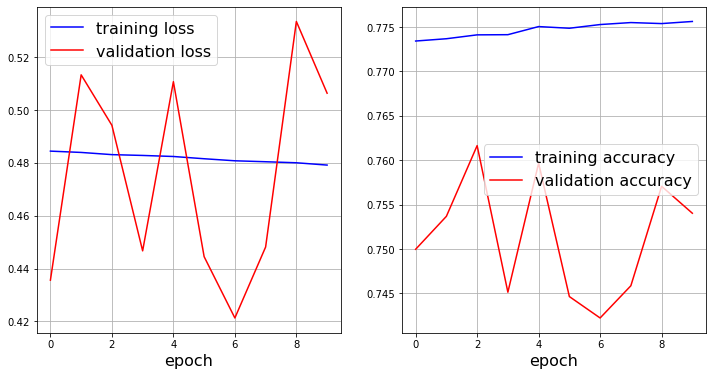

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='training loss')
ax[0].plot(np.arange(0,len(loss_val_list)), loss_val_list, '-r', label='validation loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].plot(np.arange(0,len(acc_train_list)), acc_train_list, '-b', label='training accuracy')
ax[1].plot(np.arange(0,len(acc_val_list)), acc_val_list, '-r', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

### You may train the model for more than 10 epochs and see if you can get a better result

In [ ]:
#optional

In [ ]:
#to change the learning rate during traning, we may do this
for g in optimizer.param_groups:
    g['lr']=0.001

### after training, we load the best model from the harddrive and evaluate the model on the test set
You may get a different result because of random initialization of network parameters

In [78]:
# load the best model
bestModel = np.argmax(acc_val_list)

filename_best='NN_binary_classification_Pytorch_e' + str(bestModel) + '.pt'
load_checkpoint(filename_best, model, optimizer, device)

In [79]:
#get the loss and accuracy on the test set
loss_test, acc_test = test(model, dataloader_test, device)
print('test loss:', loss_test)
print('test accuracy', acc_test)

test loss: 0.4942997749934573
test accuracy 0.74841714
